In [4]:
import math
import warnings
import datetime
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from tensorflow.keras import Sequential
from pandas_datareader import DataReader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, LSTM

warnings.filterwarnings("ignore")

stock = "TSLA"
num_of_years = 10
start_date = datetime.datetime.now() - datetime.timedelta(days=int(365.23*num_of_years))
end_date = datetime.date.today()

In [5]:
df = DataReader(stock, "yahoo", start_date, end_date)
data = df.filter(['Close'])
dataset = data.values
train_data_len = math.ceil(len(dataset)*.8)

#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

#create the training dataset
train_data = scaled_data[0:train_data_len, :]

#split the data into x_train and y_train dataset
x_train=[]
y_train=[]

for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
  if i<=61:
    #print(x_train)
    #print(y_train)
    print()

#convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#reshape the data to 3 dimension
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [7]:
#build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#compile the model
model.compile(optimizer='adam', loss='MAPE', metrics=['accuracy'])

#train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)

#create test dataset
test_data = scaled_data[train_data_len-60:, :]

#create dataset x_test, y_test
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i, 0])

#convert data to numpy array
x_test = np.array(x_test)

#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

Epoch 1/5
1953/1953 [==============================] - 47s 24ms/step - loss: 34.5301 - accuracy: 0.0000e+00
Epoch 2/5
1953/1953 [==============================] - 48s 24ms/step - loss: 19.7746 - accuracy: 0.0000e+00
Epoch 3/5
1953/1953 [==============================] - 41s 21ms/step - loss: 16.1160 - accuracy: 0.0000e+00
Epoch 4/5
1953/1953 [==============================] - 39s 20ms/step - loss: 13.2566 - accuracy: 0.0000e+00
Epoch 5/5
1953/1953 [==============================] - 41s 21ms/step - loss: 12.3182 - accuracy: 0.0000e+00


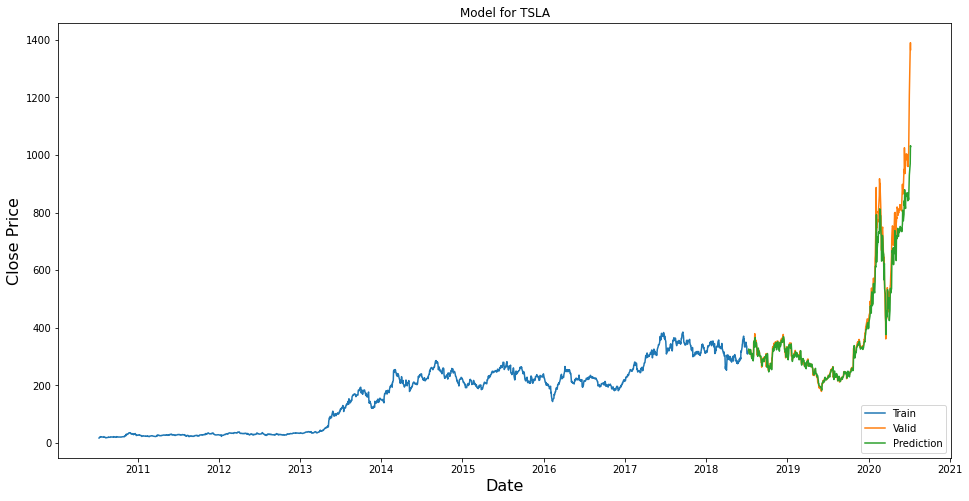

Close  Predictions
Date                                
2018-07-10   322.470001   322.516327
2018-07-11   318.959991   326.288696
2018-07-12   316.709991   317.478241
2018-07-13   318.869995   310.382111
2018-07-16   310.100006   313.147766
...                 ...          ...
2020-07-01  1119.630005   916.912537
2020-07-02  1208.660034   930.029358
2020-07-06  1371.579956   970.051880
2020-07-07  1389.859985  1032.216675
2020-07-08  1365.880005  1029.231201

[503 rows x 2 columns]
The accuracy of the LSTM Model predicting the movement of a stock each day is 49.6%
     Valid Movement  Predicted Movement
0                 1                   0
1                 1                   1
2                 0                   1
3                 1                   0
4                 0                   1
..              ...                 ...
497               0                   0
498               0                   0
499               0                   0
500               0          

In [8]:
#get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions-y_test)**2))

#plot the data
train = data[:train_data_len]
valid = data[train_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model for {}'.format(stock.upper()))
plt.xlabel('Date', fontsize=16)
plt.ylabel('Close Price', fontsize=16)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Valid','Prediction'],loc='lower right')
plt.show()

print (valid)

# find the accuracy based on predicting day-to-day movements 
valid_movement = []
pred_movement = []
close_prices = valid.Close.tolist()
pred_prices = valid.Predictions.tolist()
        
n = 0

for index, value in enumerate(close_prices[:-1]):
    if value > close_prices[index+1]: 
        valid_movement.append(1)
    else:
        valid_movement.append(0)

for index, value in enumerate(pred_prices[:-1]):
    if value > pred_prices[index+1]: 
        pred_movement.append(1)
    else:
        pred_movement.append(0)

for val, pred in zip(valid_movement, pred_movement):
    if val == pred:
        n=n+1
    else:
        pass

total = len(valid_movement)
accuracy = n/total
print (f'The accuracy of the LSTM Model predicting the movement of a stock each day is {100 * round(accuracy, 3)}%')

dataframe = pd.DataFrame(list(zip(valid_movement, pred_movement)), columns =['Valid Movement', 'Predicted Movement'])
print (dataframe)

#get predicted price for next day
last_60day = data[-60:].values
last_60day_scaled = scaler.transform(last_60day)
xx_test = []
xx_test.append(last_60day_scaled)
xx_test = np.array(xx_test)
xx_test = np.reshape(xx_test, (xx_test.shape[0], xx_test.shape[1],1))
pred = model.predict(xx_test)
pred = scaler.inverse_transform(pred)
pred = pred[0]
pred = pred[0]
print("The predicted price for the next trading day is: {}".format(round(pred, 2)))

#get stats
#Root mean squared error 
print (f'The root mean squared error is {round(rmse, 2)}')

error = mean_squared_error(valid['Close'].tolist(), valid['Predictions'].tolist())
print('Testing Mean Squared Error: %.3f' % error)